In [55]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
from datetime import datetime

In [20]:
with open('mock_data_varied_timestamps.json') as file:
    raw = json.load(file)

In [21]:
df = pd.DataFrame(raw)
df

,timestamp,type,confidence,longitude,latitude,feels_like_temp_celsius,actual_temp_celsius,wind_force_bft,wind_direction
0,2025-05-20T00:45:00Z,peuk,0.88,52.21325,54.68617,21.6,20.8,2,W
1,2025-05-20T00:39:00Z,peuk,0.77,52.23584,54.64976,19.9,14.7,5,NW
2,2025-05-20T00:23:00Z,verpakking,0.78,52.22220,54.63515,18.4,14.0,4,NW
3,2025-05-20T00:57:00Z,peuk,0.74,52.20960,54.66502,15.9,15.5,2,SW
4,2025-05-20T01:08:00Z,peuk,0.80,52.25174,54.66603,20.4,19.6,2,SE
...,...,...,...,...,...,...,...,...,...
208,2025-05-22T21:12:00Z,verpakking,0.92,52.25832,54.68409,12.2,12.1,3,S
209,2025-05-22T22:00:00Z,verpakking,0.94,52.22736,54.68387,16.5,18.8,5,E
210,2025-05-22T22:54:00Z,peuk,0.71,52.21876,54.67670,13.5,12.7,1,SE
211,2025-05-22T23:10:00Z,papier,0.86,52.20440,54.66624,13.9,21.3,3,SW


In [22]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 

In [23]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df

,timestamp,type,confidence,longitude,latitude,feels_like_temp_celsius,actual_temp_celsius,wind_force_bft,wind_direction,day_of_week,month
0,2025-05-20 00:45:00+00:00,peuk,0.88,52.21325,54.68617,21.6,20.8,2,W,1,5
1,2025-05-20 00:39:00+00:00,peuk,0.77,52.23584,54.64976,19.9,14.7,5,NW,1,5
2,2025-05-20 00:23:00+00:00,verpakking,0.78,52.22220,54.63515,18.4,14.0,4,NW,1,5
3,2025-05-20 00:57:00+00:00,peuk,0.74,52.20960,54.66502,15.9,15.5,2,SW,1,5
4,2025-05-20 01:08:00+00:00,peuk,0.80,52.25174,54.66603,20.4,19.6,2,SE,1,5
...,...,...,...,...,...,...,...,...,...,...,...
208,2025-05-22 21:12:00+00:00,verpakking,0.92,52.25832,54.68409,12.2,12.1,3,S,3,5
209,2025-05-22 22:00:00+00:00,verpakking,0.94,52.22736,54.68387,16.5,18.8,5,E,3,5
210,2025-05-22 22:54:00+00:00,peuk,0.71,52.21876,54.67670,13.5,12.7,1,SE,3,5
211,2025-05-22 23:10:00+00:00,papier,0.86,52.20440,54.66624,13.9,21.3,3,SW,3,5


In [32]:
df_grouped = df.groupby(df['timestamp'].dt.floor('d')).agg({
    'type': 'count',
    'feels_like_temp_celsius': 'mean',
    'actual_temp_celsius': 'mean',
    'wind_force_bft': 'mean',
    'day_of_week': 'min',
    'month': 'min',
}).reset_index(False)
df_grouped = df_grouped.rename(columns={'type': 'amount'})
df_grouped

,timestamp,amount,feels_like_temp_celsius,actual_temp_celsius,wind_force_bft,day_of_week,month
0,2025-05-20 00:00:00+00:00,70,17.385714,16.854286,3.100000,1,5
1,2025-05-21 00:00:00+00:00,67,17.253731,17.150746,2.985075,2,5
2,2025-05-22 00:00:00+00:00,76,16.843421,16.797368,3.355263,3,5


In [48]:
alpha = 0.5
std = df_grouped['amount'].std()
mean = df_grouped['amount'].mean()
print(mean, std)

def find_category(value):
    if value > mean+std*alpha:
        return 'high'
    elif value < mean-std*alpha:
        return 'low'
    else:
        return 'medium'

71.0 4.58257569495584


In [49]:
df_grouped['trash_level'] = df_grouped['amount'].apply(find_category)
df_grouped

,timestamp,amount,feels_like_temp_celsius,actual_temp_celsius,wind_force_bft,day_of_week,month,trash_level
0,2025-05-20 00:00:00+00:00,70,17.385714,16.854286,3.100000,1,5,medium
1,2025-05-21 00:00:00+00:00,67,17.253731,17.150746,2.985075,2,5,low
2,2025-05-22 00:00:00+00:00,76,16.843421,16.797368,3.355263,3,5,high


In [50]:
features = ['feels_like_temp_celsius','actual_temp_celsius','wind_force_bft','day_of_week','month']
X = df_grouped[features]
y = df_grouped['trash_level']

In [54]:
# model = RandomForestClassifier(criterion='entropy', n_estimators=5, max_depth=3)
# model.fit(X, y)

RandomForestClassifier()

In [56]:
model = DecisionTreeClassifier(max_depth = 2) 
model.fit(X,y)

DecisionTreeClassifier(max_depth=2)

In [57]:
from sklearn import tree
import graphviz

def plot_tree_classification(model, features, class_names):

    dot_data = tree.export_graphviz(model, out_file=None, 
                          feature_names=features,  
                          class_names=class_names,  
                          filled=True, rounded=True,  
                          special_characters=True)  

    # Turn into graph using graphviz
    graph = graphviz.Source(dot_data)  

    # Write out a pdf
    graph.render("decision_tree")

    # Display in the notebook
    return graph 

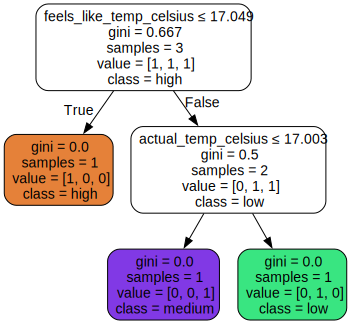

In [58]:
import numpy as np
plot_tree_classification(model, features, np.sort(df_grouped.trash_level.unique()))

In [37]:
for i, value in enumerate(['a', 'b']):
    print(value, i)

a 0
b 1


In [38]:
type_mapping = {v: k for k, v in enumerate(df['type'].unique())}
# df['type_encoded'] = df['type'].map(type_mapping)
type_mapping

{'peuk': 0,
 'verpakking': 1,
 'papier': 2,
 'glas': 3,
 'blikje': 4,
 'plastic flesje': 5}

In [ ]:
joblib.dump((model, type_mapping), 'trash_model.pkl')